<h2>Dataset Link</h2>

https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch/data

<h2>Data Cleaning</h2>

In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import contractions
import demoji
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Download NLTK resources
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

In [2]:
df = pd.read_csv('Dataset/Suicide_Detection.csv')
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [3]:
df.tail()

,Unnamed: 0,text,class
232069,348103,If you don't like rock then your not going to ...,non-suicide
232070,348106,You how you can tell i have so many friends an...,non-suicide
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
232072,348108,The usual stuff you find hereI'm not posting t...,suicide
232073,348110,I still haven't beaten the first boss in Hollo...,non-suicide


In [4]:
df = df[['text', 'class']]
df = df[:10000] # limit to 10,000 dataset
df['class'].value_counts()

class
non-suicide    5085
suicide        4915
Name: count, dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df.isna().sum()

text     0
class    0
dtype: int64

In [7]:
df['text'][0]

"Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice and lied to me so much that I have decided to refuse to go back to her. As of a few days ago, she began threatening suicide. I have tirelessly spent these paat few days talking her out of it and she keeps hesitating because she wants to believe I'll come back. I know a lot of people will threaten this in order to get their way, but what happens if she really does? What do I do and how am I supposed to handle her death on my hands? I still love my wife but I cannot deal with getting cheated on again and constantly feeling insecure. I'm worried today may be the day she does it and I hope so much it doesn't happen."

In [8]:
df['text'][150]

'Feeling really angry can someone talk?I would appreciate it if I may vent my heart..'

In [9]:
df['text'][1880]

'I’m in a hole that’s to deepI owe someone money and I know they are going to sue me because they are from a wealthy family.... I will lose everything, I don’t wanna be here anymore and my stupidity is the reason for it. It’s my ex girlfriend btw.... I never thought she would be this cold.'

In [10]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower() # Lowercase
    text = demoji.replace_with_desc(text) # # Convert emojis to text
    text = contractions.fix(text) # Expand contractions
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove special characters and symbols
    text = re.sub(r'\d+', '', text) # Remove digits
    text = BeautifulSoup(text, "html.parser").get_text() # Remove HTML tags
    text = re.sub(r'\b[a-zA-Z]\b', '', text) # Remove single letters
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    
    # Tokenize
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords and lemmatize
    cleaned_tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words
    ]
    
    # Rejoin tokens back --> string
    cleaned_text = ' '.join(cleaned_tokens)
    
    return cleaned_text


df['text'] = df['text'].apply(preprocess_text)
df.head()

,text,class
0,ex wife threatening suiciderecently left wife ...,suicide
1,weird get affected compliment coming someone k...,non-suicide
2,finally almost never hear bad year ever swear ...,non-suicide
3,need helpjust help cry hard,suicide
4,losthello name adam struggling year afraid pas...,suicide


In [11]:
# Saved the cleaned dataset.
df.to_csv('Dataset/cleaned_df.csv')

In [12]:
cleaned_df = pd.read_csv('Dataset/cleaned_df.csv')
cleaned_df.head()

,Unnamed: 0,text,class
0,0,ex wife threatening suiciderecently left wife ...,suicide
1,1,weird get affected compliment coming someone k...,non-suicide
2,2,finally almost never hear bad year ever swear ...,non-suicide
3,3,need helpjust help cry hard,suicide
4,4,losthello name adam struggling year afraid pas...,suicide


In [13]:
cleaned_df.isna().sum()

Unnamed: 0    0
text          6
class         0
dtype: int64

In [14]:
cleaned_df[cleaned_df['text'].isna()]

,Unnamed: 0,text,class
408,408,NaN,non-suicide
3708,3708,NaN,non-suicide
3946,3946,NaN,non-suicide
5577,5577,NaN,non-suicide
8231,8231,NaN,non-suicide
9592,9592,NaN,non-suicide


In [15]:
cleaned_df.dropna(inplace=True)

In [16]:
x = cleaned_df['text']
y = cleaned_df['class']

In [17]:
vectorizer = TfidfVectorizer(min_df=50,max_features=5000)
x =  vectorizer.fit_transform(x).toarray()

In [18]:
# Save the vectorizer
with open('tfidf.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)  

<h2>Machine Learning</h2>

In [19]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [20]:
ML_model = LogisticRegression(random_state=42)
ML_model.fit(X_train, y_train)
print('Training score:',ML_model.score(X_train, y_train))
print('Testing score:',ML_model.score(X_test,y_test))

Training score: 0.9203252032520325
Testing score: 0.8989494747373686


In [21]:
y_pred = ML_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

 non-suicide       0.89      0.91      0.90       998
     suicide       0.91      0.89      0.90      1001

    accuracy                           0.90      1999
   macro avg       0.90      0.90      0.90      1999
weighted avg       0.90      0.90      0.90      1999



In [22]:
# Save ML_model
with open('ML_model.pkl', 'wb') as f:
    pickle.dump(ML_model, f)

<h2>Deep Learning</h2>

In [23]:
x = cleaned_df['text'].values
y = cleaned_df['class'].values

In [24]:
le = LabelEncoder()
y = le.fit_transform(y)

In [25]:
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print(label_mapping)

{'non-suicide': 0, 'suicide': 1}


In [26]:
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(cleaned_df['text'])
sequences = tokenizer.texts_to_sequences(cleaned_df['text'])
padded = pad_sequences(sequences, maxlen=100)

X_train,X_test,y_train,y_test = train_test_split(padded,y,test_size=0.2,random_state=42)

In [27]:
DL_model = Sequential()
DL_model.add(Embedding(input_dim=5000, output_dim=100))
DL_model.add(LSTM(128))
DL_model.add(Dropout(0.3))
DL_model.add(Dense(1, activation='sigmoid'))

DL_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = DL_model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 69s 198ms/step - accuracy: 0.7963 - loss: 0.4563 - val_accuracy: 0.9015 - val_loss: 0.2581
Epoch 2/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 47s 188ms/step - accuracy: 0.9245 - loss: 0.2021 - val_accuracy: 0.9040 - val_loss: 0.2467
Epoch 3/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 218ms/step - accuracy: 0.9530 - loss: 0.1412 - val_accuracy: 0.9065 - val_loss: 0.2670


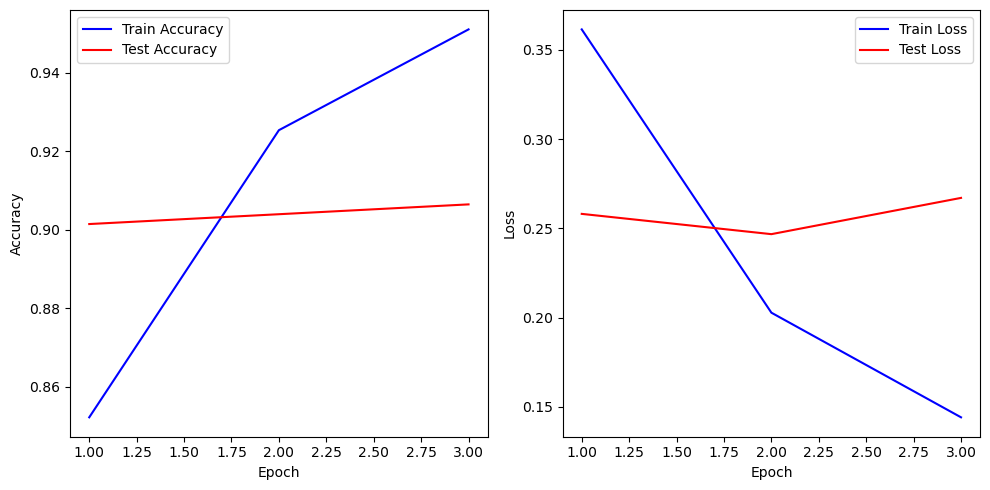

In [28]:
# learning curve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
# creating subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(epochs, acc, 'b', label='Train Accuracy')
axes[0].plot(epochs, val_acc, 'r', label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'b', label='Train Loss')
axes[1].plot(epochs, val_loss, 'r', label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# adusting layout for better spacing
plt.tight_layout()

# display the figure
plt.show();

In [29]:
pred = DL_model.predict(X_test)
y_pred = (pred>0.5)

cr = classification_report(y_test, y_pred)
print(cr)

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       998
           1       0.90      0.91      0.91      1001

    accuracy                           0.91      1999
   macro avg       0.91      0.91      0.91      1999
weighted avg       0.91      0.91      0.91      1999



<h2>Machine Learning vs Deep Learning</h2>

In [30]:
# Machine Learning
with open('tfidf.pkl', 'rb') as f:
    vectorizer = pickle.load(f)
with open('ML_model.pkl', 'rb') as f:
    ML_model = pickle.load(f)

text_input = "I want to die"
cleaned_text = preprocess_text(text_input)
vectorized = vectorizer.transform([cleaned_text])
ML_prediction = ML_model.predict(vectorized)
print("ML Predicted class:", ML_prediction[0])

#Deep Learning
def DL_predict_text(text):
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq, maxlen=100)
    pred = DL_model.predict(pad)
    pred_class = 1 if pred >= 0.5 else 0
    return le.inverse_transform([pred_class])[0]

print("DL Predicted class:", DL_predict_text(text_input))

ML Predicted class: suicide
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
DL Predicted class: suicide
